In [103]:
#python libraries
import os, re, sys, copy, importlib

#other ML libraries
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import LSTMCoSTA

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

### DATA CLEANING

In [104]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#, format="ISO8601")#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### FEATURE ENGINEERING ###

In [105]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [106]:
sensor_data.describe()

,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,...,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,0.731093,20.219920,20.493444,19.880145,0.159577,0.003396,0.113925,23.061776,18.888458,38.371860,...,21.596080,20.351772,0.398739,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,0.443397,2.777353,2.358416,2.570392,0.366218,0.058175,0.317725,1.703731,3.133083,9.052182,...,2.549447,3.360557,0.489645,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,0.000000,10.250000,15.100000,14.150000,0.000000,0.000000,0.000000,15.300000,5.700000,19.000000,...,10.550000,10.525000,0.000000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,0.000000,18.800000,18.750000,18.050000,0.000000,0.000000,0.000000,22.300000,17.650000,31.000000,...,20.100000,18.383333,0.000000,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,1.000000,20.200000,20.483333,19.750000,0.000000,0.000000,0.000000,23.450000,19.200000,37.000000,...,21.550000,20.200000,0.000000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,1.000000,22.000000,22.100000,21.650000,0.000000,0.000000,0.000000,24.250000,20.925000,45.000000,...,23.300000,22.366667,1.000000,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,1.000000,27.450000,31.550000,27.750000,1.000000,1.000000,1.000000,26.900000,28.200000,67.000000,...,30.700000,32.425000,1.000000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [107]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [108]:
radiation_df = pd.read_csv("./shortwave-radiation.csv", delimiter=";", index_col=2, decimal=",")[:-1]
radiation_df = radiation_df.drop(columns=["Navn", "Stasjon"])
radiation_df.index = pd.to_datetime(radiation_df.index, utc=True, dayfirst=True)
radiation_df = radiation_df.sort_index()
radiation_df = radiation_df.resample('15T').mean().interpolate()
data["radiation"] = radiation_df.loc[(radiation_df.index >= data.index[0]) & (radiation_df.index <= data.index[-1])]/100

In [109]:
train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()

outdoor_temp_columns = data.columns.str.endswith('OutdoorEntrance_temperature')
indoor_temp_columns = data.columns.str.endswith('temperature') & np.logical_not(outdoor_temp_columns)
door_columns = data.columns.str.endswith('door')
timing_columns = data.columns.str.startswith('sin_') | data.columns.str.startswith('cos_')
radiation_column = data.columns.str.startswith('radiation')

lstm_train_df_1 = train_df_1.copy()
lstm_train_df_1.loc[:, indoor_temp_columns | outdoor_temp_columns] = lstm_train_df_1.loc[:, indoor_temp_columns | outdoor_temp_columns].diff().shift(-1).dropna()
lstm_train_df_1 = lstm_train_df_1.dropna()
lstm_train_df_2 = train_df_2.copy()
lstm_train_df_2.loc[:, indoor_temp_columns | outdoor_temp_columns] = lstm_train_df_2.loc[:, indoor_temp_columns | outdoor_temp_columns].diff().shift(-1).dropna()
lstm_train_df_2 = lstm_train_df_2.dropna()
lstm_val_df = val_df.copy()
lstm_val_df.loc[:, indoor_temp_columns | outdoor_temp_columns] = lstm_val_df.loc[:, indoor_temp_columns | outdoor_temp_columns].diff().shift(-1).dropna()
lstm_val_df = lstm_val_df.dropna()

lstm_scaler = StandardScaler().fit(pd.concat([lstm_train_df_1, lstm_train_df_2, lstm_val_df]))

In [110]:
import HAMDataset
importlib.reload(HAMDataset)
warmup_length = 96
label_length = 8
train_data = HAMDataset.Dataset(label_length, warmup_length, indoor_temp_columns, outdoor_temp_columns, radiation_column, door_columns, timing_columns, is_lstm=True, x_scaler=lstm_scaler)
train_data.add_data(train_df_1)
train_data.add_data(train_df_2)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

val_data = HAMDataset.Dataset(label_length, warmup_length, indoor_temp_columns, outdoor_temp_columns, radiation_column, door_columns, timing_columns, is_lstm=True, x_scaler=lstm_scaler)
val_data.add_data(val_df)
val_loader = DataLoader(val_data, batch_size=100, shuffle=False)

test_data = HAMDataset.Dataset(label_length, warmup_length, indoor_temp_columns, outdoor_temp_columns, radiation_column, door_columns, timing_columns, is_lstm=True, x_scaler=lstm_scaler)
test_data.add_data(test_df)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [111]:
warmup_indoor, warmup_outdoor, warmup_radiation, indoor_temp, outdoor_temp, radiation, door, timing, labels, lstm_input = next(iter(train_loader))

### DEFINE PBM MODEL

In [112]:
import asset
import PBM
import importlib
importlib.reload(PBM)
importlib.reload(asset)

gfBedroom = asset.Zone("gfBedroom",       [0.34146, 1.36584, 1.36584, 0.34146],           [41652.8784, 402850.8])
gfLivingroom = asset.Zone("gfLivingroom", [0.598068, 2.392272, 2.392272, 0.598068],       [157355.3184, 747837.36])
stairs = asset.Zone("stairs",             [0.4067498, 1.6269992, 1.6269992, 0.4067498],   [69035.7892, 647290.4264])
gfBath = asset.Zone("gfBath",             [0.2705976, 1.0823904, 1.0823904, 0.2705976],   [44159.7646, 434698.992])
gfStorage = asset.Zone("gfStorage",       [0.2901384, 1.1605536, 1.1605536, 0.2901384],   [49173.537, 466090.128])
f1Guestroom = asset.Zone("f1Guestroom",   [0.366948, 1.467792, 1.467792, 0.366948],       [49944.8866, 443795.76])
f1Mainroom = asset.Zone("f1Mainroom",     [0.421254, 1.685016, 1.685016, 0.421254],       [66721.7404, 525431.88])
f1Sleep3 = asset.Zone("f1Sleep3",         [0.370791, 1.483164, 1.483164, 0.370791],       [49559.2118, 486390.42])
f1Bath = asset.Zone("f1Bath",             [0.172752, 0.691008, 0.691008, 0.172752],       [37796.1304, 277515.84])
f1Storage = asset.Zone("f1Storage",       [0.423831, 1.695324, 1.695324, 0.423831],       [26033.049, 673890.636])
f1Entrance = asset.Zone("f1Entrance",     [0.123192, 0.492768, 0.492768, 0.123192],       [88512.3666, 197900.64])
f2Livingroom = asset.Zone("f2Livingroom", [2.6243349, 10.4973396, 10.4973396, 2.6243349], [345178.946, 3373189.904])
f2Office = asset.Zone("f2Office",         [0.3805635, 1.522254, 1.522254, 0.3805635],     [42424.228, 462828.5916])
zones = [gfBedroom, gfLivingroom, stairs, gfBath, gfStorage, f1Guestroom, f1Mainroom, f1Sleep3, f1Bath, f1Storage, f1Entrance, f2Livingroom, f2Office]

connections =  [{"rooms": ["gfBedroom", "gfLivingroom"],    "R": 10.35216, "C": 179373.6}, 
                {"rooms": ["gfBedroom", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfBedroom", "f1Guestroom"],     "R": 2.016, "C": 207012.6},
                {"rooms": ["gfLivingroom", "gfBath"],       "R": 9.785256, "C": 169550.76},
                {"rooms": ["gfLivingroom", "stairs"],       "R": 38.10888, "C": 0},
                {"rooms": ["gfLivingroom", "f1Entrance"],   "R": 2.7216, "C": 279467.01},
                {"rooms": ["gfLivingroom", "f1Mainroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["gfBath", "gfStorage"],          "R": 5.91552, "C": 102499.2},
                {"rooms": ["gfBath", "f1Sleep3"],           "R": 1.12896, "C": 115927.056},
                {"rooms": ["gfStorage", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfStorage", "f1Bath"],          "R": 1.82784, "C": 187691.424},
                {"rooms": ["f1Guestroom", "f1Mainroom"],    "R": 7.3944, "C": 128124},
                {"rooms": ["f1Guestroom", "f1Entrance"],    "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "stairs"],        "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "f2Livingroom"],  "R": 2.4192, "C": 248415.12},
                {"rooms": ["f1Mainroom", "f1Sleep3"],       "R": 5.17608, "C": 89686.8},
                {"rooms": ["f1Mainroom", "f1Entrance"],     "R": 6.65496, "C": 115311.6},
                {"rooms": ["f1Mainroom", "f2Livingroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["f1Sleep3", "f1Entrance"],       "R": 12.57048, "C": 217810.8},
                {"rooms": ["f1Sleep3", "f2Livingroom"],     "R": 2.39904, "C": 246344.994},
                {"rooms": ["f1Entrance", "f1Bath"],         "R": 3.94368, "C": 68332.8},
                {"rooms": ["f1Entrance", "stairs"],         "R": 38.10888, "C": 0},
                {"rooms": ["f1Entrance", "f2Livingroom"],   "R": 4.28064, "C": 439556.754},
                {"rooms": ["f1Bath", "f1Storage"],          "R": 0.72216, "C": 116010.72},
                {"rooms": ["f1Bath", "stairs"],             "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Bath", "f2Office"],           "R": 1.82784, "C": 187691.424},
                {"rooms": ["f2Livingroom", "f2Office"],     "R": 12.089844, "C": 209482.74},
                {"rooms": ["f2Livingroom", "stairs"],       "R": 43.131254, "C": 0},
                {"rooms": ["f2Office", "stairs"],           "R": 4.729335, "C": 81945.975}]

house = asset.Asset(zones, connections)

thermoPBM = PBM.thermoPBM(house)

In [113]:
pbm_out = torch.zeros((test_df.shape[0]-96-8-1,  13))
pbm_out_wall = torch.zeros((test_df.shape[0]-96-8-1, 13))
true_temp = torch.zeros((test_df.shape[0]-96-8-1, 13))

delta_t = 60
N = 15

for i, (warmup_indoor, warmup_outdoor, warmup_radiation, indoor_temp, outdoor_temp, radiation, door, timing, labels, lstm_input) in enumerate(test_loader):
    if i == 0:
        T_room_warmup = LSTMCoSTA.pbm_temp_from_sensor(indoor_temp)
        T_wall_warmup = torch.zeros_like(T_room_warmup)
    

        for n in range(warmup_indoor.shape[1]):
            for _ in range(N):
                T_room_warmup, T_wall_warmup = thermoPBM(T_room_warmup, T_wall_warmup, warmup_outdoor[:, n, :], warmup_radiation[:, n, :], delta_t)


        T_room = LSTMCoSTA.pbm_temp_from_sensor(indoor_temp)
        T_wall = T_wall_warmup

    pbm_out[i] = T_room
    pbm_out_wall[i] = T_wall
    true_temp[i] = LSTMCoSTA.pbm_temp_from_sensor(indoor_temp)
    
    for _ in range(N):
        T_room, T_wall = thermoPBM(T_room, T_wall, outdoor_temp[0, 0], radiation[0, 0], delta_t)
    


In [114]:
torch.mean(torch.abs(pbm_out-true_temp))

tensor(1.8322, grad_fn=<MeanBackward0>)

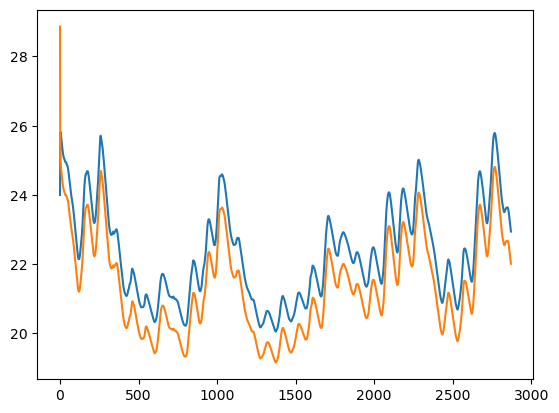

In [128]:
plt.plot(pbm_out[:, 0].detach().numpy(), label="PBM")
plt.plot(pbm_out[:, -2].detach().numpy(), label="PBM")


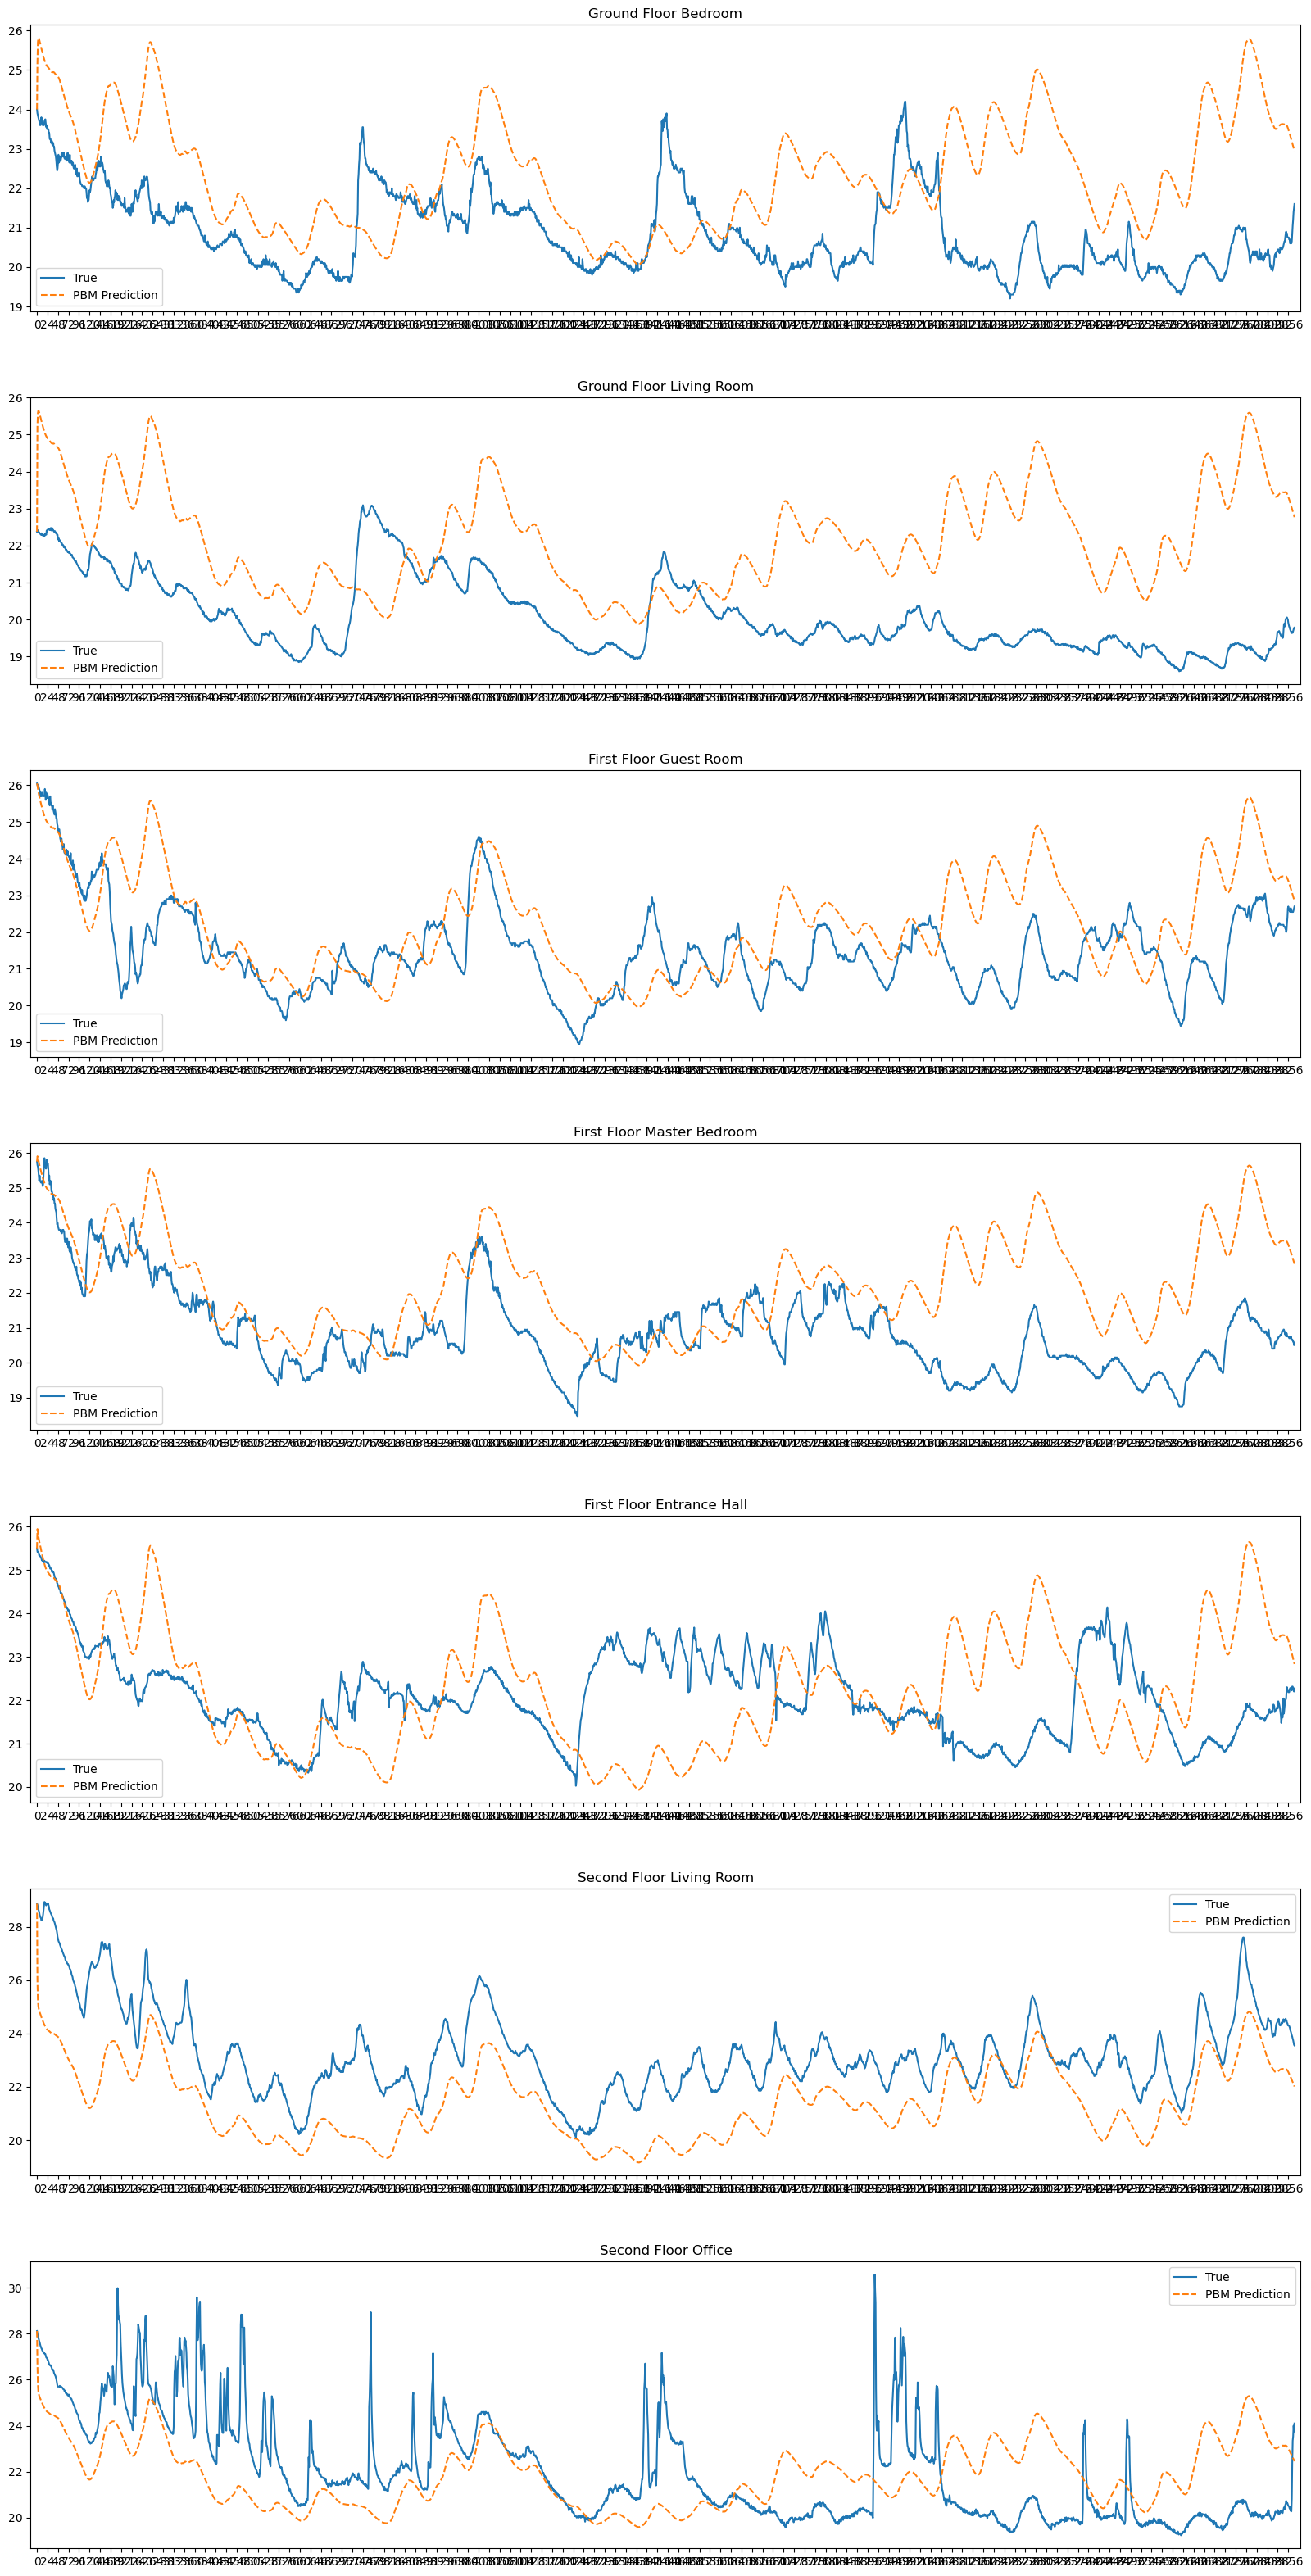

In [129]:
titles = ["Ground Floor Bedroom", "Ground Floor Living Room", "First Floor Guest Room",
          "First Floor Master Bedroom", "First Floor Entrance Hall",
          "Second Floor Living Room", "Second Floor Office"]
pred_order = ['0BRoom_temperature', '0BTLivingRoom_temperature',
             '1GuestRoom_temperature','1MainRoom_temperature', 
             '1Entrance_temperature', '2LivingRoomCenter_temperature',
            '2OfficeDesk_temperature']
pbm_compare_indices = [0, 1, 5, 6, 10, 11, 12]
label_compare_indices = [0, 1, 3, 4, 2, 7, 8]

fig,ax = plt.subplots(7,1,figsize=(20,40))
plt.subplots_adjust(hspace=0.3)

for i in range(len(pbm_compare_indices)):
    true = true_temp[:, pbm_compare_indices[i]].flatten()
    pbm_pred = pbm_out.detach()[:, pbm_compare_indices[i]].flatten()
    x = range(len(true))
    ax[i].plot(x, true, label="True")
    ax[i].plot(x, pbm_pred, '--', label="PBM Prediction")
    # ax[i].plot(x, pbm_pred, '--', label="PBM Prediction")
    ax[i].set_title(f"{titles[i]}")
    ax[i].set_xticks(x[::24])
    # ax[i].set_xticklabels([date.strftime("%a %d.%m") for date in pbm_pred.index[::24].date], rotation=45)
    ax[i].margins(x=0.005)
    # ax[i].vlines(x = range(0, len(true), 96), ymax=np.max(np.maximum.reduce([true, pbm_pred])), ymin=np.min(np.minimum.reduce([true, pbm_pred])), linestyles='dotted', colors='c', label='DDM Corrected')
    ax[i].legend()

MAE: 1.7719566822052002


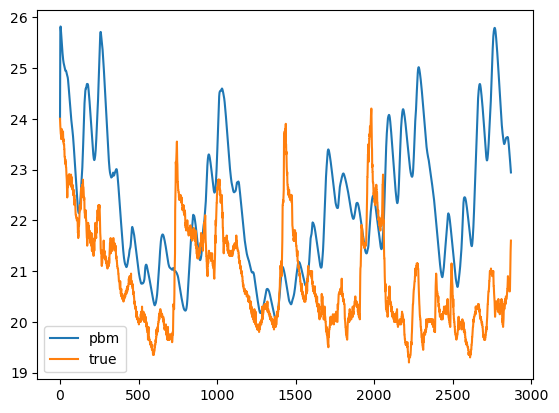

In [116]:
plt.plot(pbm_out.detach()[:, 0], label="pbm")
# plt.plot(pbm_out_wall.detach()[:, 0], label="pbm wall")
plt.plot(true_temp[:, 0], label="true")
plt.legend()
print(f'MAE: {torch.mean(torch.abs(true_temp[:, 0] - pbm_out[:, 0]))}')

### CoSTA

In [117]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [118]:
import LSTMModel
importlib.reload(LSTMModel)
importlib.reload(PBM)

house = asset.Asset(zones, connections)
thermoPBM = PBM.thermoPBM(house)

In [119]:
importlib.reload(LSTMModel)
importlib.reload(LSTMCoSTA)

NNModel = LSTMModel.Net(input_size=23, hidden_size=64, output_shape=26,
                      num_lstm_layers=1, linear_layers=[90, 64], 
                      bidir=False, dropout_p=0.4)

CoSTA = LSTMCoSTA.LSTMCoSTA(thermoPBM, NNModel)

# count_parameters(CoSTA)

epochs = 1000
lr = 0.001
l2_reg = 0.001

CoSTA.train(train_loader, val_loader, epochs, lr, l2_reg)

KeyboardInterrupt: 

In [ ]:
importlib.reload(LSTMModel)
importlib.reload(LSTMCoSTA)

NNModel = LSTMModel.Net(input_size=22, hidden_size=64, output_shape=26,
                      num_lstm_layers=1, linear_layers=[90, 64, 64], 
                      bidir=False)

CoSTA_2 = LSTMCoSTA.LSTMCoSTA(thermoPBM, NNModel)

# count_parameters(CoSTA)

epochs = 1000
lr = 0.01
l2_reg = 0.001

CoSTA_2.train(train_loader, val_loader, epochs, lr, l2_reg)

In [ ]:
importlib.reload(LSTMModel)
importlib.reload(LSTMCoSTA)

NNModel = LSTMModel.Net(input_size=22, hidden_size=64, output_shape=26,
                      num_lstm_layers=1, linear_layers=[90, 64, 64], 
                      bidir=False)

CoSTA_3 = LSTMCoSTA.LSTMCoSTA(thermoPBM, NNModel)

# count_parameters(CoSTA)

epochs = 1000
lr = 0.0001
l2_reg = 0.001

CoSTA_3.train(train_loader, val_loader, epochs, lr, l2_reg)

In [ ]:
importlib.reload(LSTMModel)
importlib.reload(LSTMCoSTA)

NNModel = LSTMModel.Net(input_size=22, hidden_size=64, output_shape=26,
                      num_lstm_layers=1, linear_layers=[90, 64, 64], 
                      bidir=False, dropout_p=0.2)

CoSTA_4 = LSTMCoSTA.LSTMCoSTA(thermoPBM, NNModel)

# count_parameters(CoSTA)

epochs = 1000
lr = 0.001
l2_reg = 0.01

CoSTA_4.train(train_loader, val_loader, epochs, lr, l2_reg)

In [ ]:
importlib.reload(LSTMModel)
importlib.reload(LSTMCoSTA)

NNModel = LSTMModel.Net(input_size=22, hidden_size=64, output_shape=26,
                      num_lstm_layers=1, linear_layers=[90, 64, 64], 
                      bidir=False, dropout_p=0.4)

CoSTA_5 = LSTMCoSTA.LSTMCoSTA(thermoPBM, NNModel)

# count_parameters(CoSTA)

epochs = 1000
lr = 0.001
l2_reg = 0.001

CoSTA_5.train(train_loader, val_loader, epochs, lr, l2_reg)

In [ ]:
importlib.reload(LSTMModel)
importlib.reload(LSTMCoSTA)

NNModel = LSTMModel.Net(input_size=22, hidden_size=64, output_shape=26,
                      num_lstm_layers=1, linear_layers=[90, 64, 64], 
                      bidir=False, dropout_p=0.0)

CoSTA_6 = LSTMCoSTA.LSTMCoSTA(thermoPBM, NNModel)

# count_parameters(CoSTA)

epochs = 1000
lr = 0.001
l2_reg = 0.001

CoSTA_6.train(train_loader, val_loader, epochs, lr, l2_reg)

In [ ]:
save_model = False
if save_model:
    torch.save(CoSTA.state_dict(), 'models/CoSTA.pt')

In [134]:
NNModel = LSTMModel.Net(input_size=23, hidden_size=64, output_shape=26,
                      num_lstm_layers=1, linear_layers=[90, 64], bidir=False)

CoSTA = LSTMCoSTA.LSTMCoSTA(thermoPBM, NNModel)
CoSTA.load_state_dict(torch.load('./models/CoSTA.pt'))

RuntimeError: Error(s) in loading state_dict for LSTMCoSTA:
	size mismatch for DDM.lstm.weight_ih_l0: copying a param with shape torch.Size([256, 22]) from checkpoint, the shape in current model is torch.Size([256, 23]).

In [133]:
sim_n = 300#len(test_data)

pbm_out = torch.zeros((sim_n, 13))
pbm_out_wall = torch.zeros((sim_n, 13))
true_temp = torch.zeros((sim_n, 13))

delta_t = 60
N = 15

for i, (warmup_indoor, warmup_outdoor, warmup_radiation, indoor_temp, outdoor_temp, radiation, door, timing, labels, lstm_input) in enumerate(list(test_loader)[:sim_n]):
    
    if i == 0:
        T_room_warmup = LSTMCoSTA.pbm_temp_from_sensor(warmup_indoor[:, 0, :])
        T_wall_warmup = torch.zeros_like(T_room_warmup)
        
        for n in range(warmup_indoor.shape[1]):
            for _ in range(N):
                T_room_warmup, T_wall_warmup = thermoPBM(T_room_warmup, T_wall_warmup, warmup_outdoor[:, n, :], warmup_radiation[:, n, :], delta_t)


        T_room = LSTMCoSTA.pbm_temp_from_sensor(indoor_temp)
        T_wall = T_wall_warmup
    
    elif i % 96 == 0:
        T_room = LSTMCoSTA.pbm_temp_from_sensor(indoor_temp)

    T_room, T_wall = CoSTA(T_room, T_wall, outdoor_temp, radiation, lstm_input, N, delta_t, 1)

    pbm_out[i] = T_room
    pbm_out_wall[i] = T_wall
    true_temp[i] = LSTMCoSTA.pbm_temp_from_sensor(labels[0, 0].unsqueeze(0))


RuntimeError: input.size(-1) must be equal to input_size. Expected 22, got 23

In [38]:
torch.mean(torch.abs(pbm_out-true_temp))

tensor(19.5588, grad_fn=<MeanBackward0>)

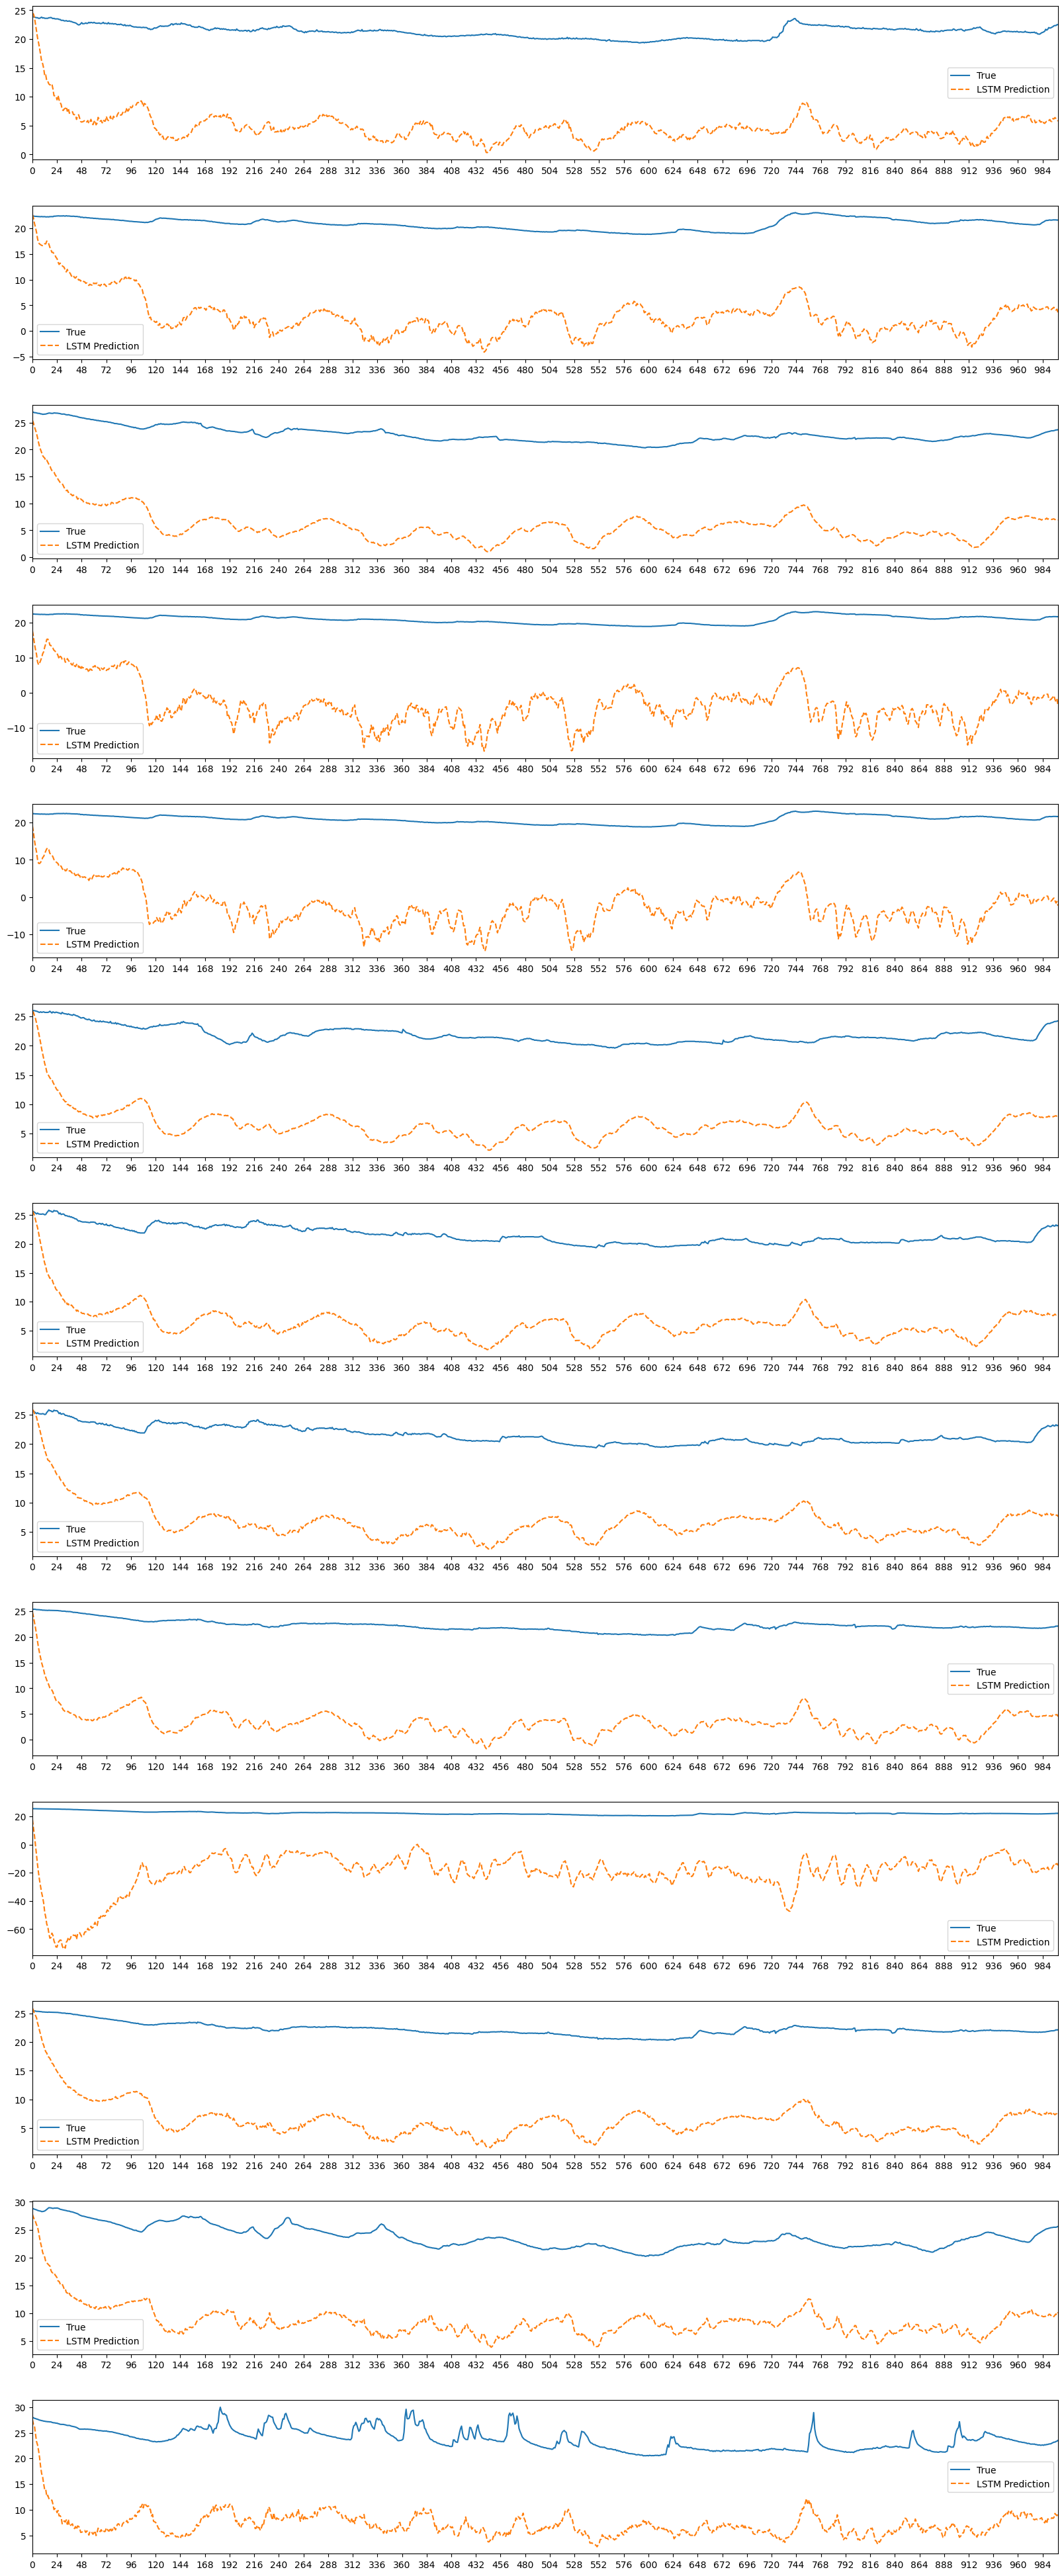

In [39]:
titles = ["Ground Floor Bedroom", "Ground Floor Living Room", "First Floor Entrance Hall",
          "First Floor Guest Room", "First Floor Master Bedroom", "Second Floor Cooking",
          "Second Floor Fireplace", "Second Floor Living Room", "Second Floor Office"]
pred_order = ['0BRoom_temperature', '0BTLivingRoom_temperature',
            '1Entrance_temperature', '1GuestRoom_temperature',
            '1MainRoom_temperature', '2Cooking_temperature',
            '2Fireplace_temperature', '2LivingRoomCenter_temperature',
            '2OfficeDesk_temperature']

plot_i = 0
fig,ax = plt.subplots(13,1,figsize=(20,50))
plt.subplots_adjust(hspace=0.3)

for i in range(pbm_out.shape[1]):
    true = true_temp[:, i].flatten()
    pbm_pred = pbm_out.detach()[:, i].flatten()
    x = range(len(true))
    ax[i].plot(x, true, label="True")
    ax[i].plot(x, pbm_pred, '--', label="LSTM Prediction")
    # ax[i].plot(x, pbm_pred, '--', label="PBM Prediction")
    # ax[i].set_title(f"{titles[i]}")
    ax[i].set_xticks(x[::24])
    # ax[i].set_xticklabels([date.strftime("%a %d.%m") for date in pbm_pred.index[::24].date], rotation=45)
    ax[i].margins(x=0)
    # ax[i].vlines(x = range(0, len(true), 96), ymax=np.max(np.maximum.reduce([true, pbm_pred])), ymin=np.min(np.minimum.reduce([true, pbm_pred])), linestyles='dotted', colors='c', label='DDM Corrected')
    ax[i].legend()

MAE: 19.16804313659668


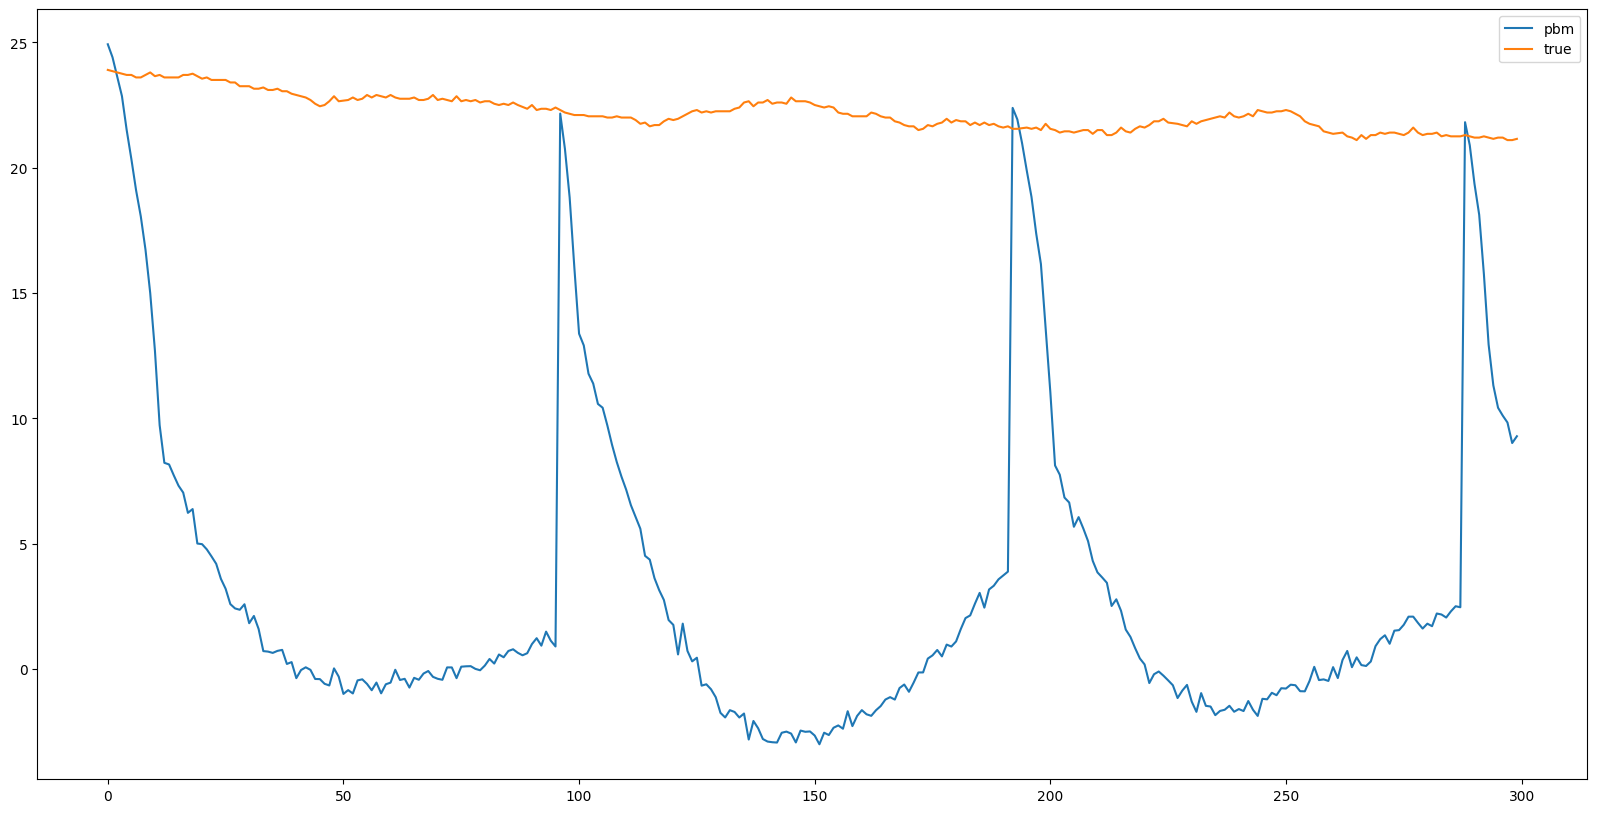

In [ ]:
room = 0
# sim_n = 400
plt.figure(figsize=(20, 10))
plt.plot(pbm_out.detach()[:sim_n, room], label="pbm")
# plt.plot(pbm_out_wall.detach()[:sim_n, room], label="pbm wall")
plt.plot(true_temp[:sim_n, room], label="true")
# plt.vlines(x = range(0, len(true), 96), ymax=np.max(np.maximum.reduce([true[:sim_n, 0].detach().numpy(), pbm_out[:sim_n, 0].detach().numpy()])), ymin=np.min(np.minimum.reduce([true[:sim_n, 0].detach().numpy(), pbm_out[:sim_n, 0].detach().numpy()])), linestyles='dotted', colors='c', label='DDM Corrected')
plt.legend()
print(f'MAE: {torch.mean(torch.abs(true_temp[:sim_n, 0] - (pbm_out[:sim_n, 0])))}')

### Sandbox

In [ ]:
import asset
import PBM
import importlib
importlib.reload(PBM)
importlib.reload(asset)

gfBedroom = asset.Zone("gfBedroom",       [0.34146, 1.36584, 1.36584, 0.34146],           [41652.8784, 402850.8])
gfLivingroom = asset.Zone("gfLivingroom", [0.598068, 2.392272, 2.392272, 0.598068],       [157355.3184, 747837.36])
stairs = asset.Zone("stairs",             [0.4067498, 1.6269992, 1.6269992, 0.4067498],   [69035.7892, 647290.4264])
gfBath = asset.Zone("gfBath",             [0.2705976, 1.0823904, 1.0823904, 0.2705976],   [44159.7646, 434698.992])
gfStorage = asset.Zone("gfStorage",       [0.2901384, 1.1605536, 1.1605536, 0.2901384],   [49173.537, 466090.128])
f1Guestroom = asset.Zone("f1Guestroom",   [0.366948, 1.467792, 1.467792, 0.366948],       [49944.8866, 443795.76])
f1Mainroom = asset.Zone("f1Mainroom",     [0.421254, 1.685016, 1.685016, 0.421254],       [66721.7404, 525431.88])
f1Sleep3 = asset.Zone("f1Sleep3",         [0.370791, 1.483164, 1.483164, 0.370791],       [49559.2118, 486390.42])
f1Bath = asset.Zone("f1Bath",             [0.172752, 0.691008, 0.691008, 0.172752],       [37796.1304, 277515.84])
f1Storage = asset.Zone("f1Storage",       [0.423831, 1.695324, 1.695324, 0.423831],       [26033.049, 673890.636])
f1Entrance = asset.Zone("f1Entrance",     [0.123192, 0.492768, 0.492768, 0.123192],       [88512.3666, 197900.64])
f2Livingroom = asset.Zone("f2Livingroom", [2.6243349, 10.4973396, 10.4973396, 2.6243349], [345178.946, 3373189.904])
f2Office = asset.Zone("f2Office",         [0.3805635, 1.522254, 1.522254, 0.3805635],     [42424.228, 462828.5916])
zones = [gfBedroom, gfLivingroom, stairs, gfBath, gfStorage, f1Guestroom, f1Mainroom, f1Sleep3, f1Bath, f1Storage, f1Entrance, f2Livingroom, f2Office]

connections =  [{"rooms": ["gfBedroom", "gfLivingroom"],    "R": 10.35216, "C": 179373.6}, 
                {"rooms": ["gfBedroom", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfBedroom", "f1Guestroom"],     "R": 2.016, "C": 207012.6},
                {"rooms": ["gfLivingroom", "gfBath"],       "R": 9.785256, "C": 169550.76},
                {"rooms": ["gfLivingroom", "stairs"],       "R": 38.10888, "C": 0},
                {"rooms": ["gfLivingroom", "f1Entrance"],   "R": 2.7216, "C": 279467.01},
                {"rooms": ["gfLivingroom", "f1Mainroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["gfBath", "gfStorage"],          "R": 5.91552, "C": 102499.2},
                {"rooms": ["gfBath", "f1Sleep3"],           "R": 1.12896, "C": 115927.056},
                {"rooms": ["gfStorage", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfStorage", "f1Bath"],          "R": 1.82784, "C": 187691.424},
                {"rooms": ["f1Guestroom", "f1Mainroom"],    "R": 7.3944, "C": 128124},
                {"rooms": ["f1Guestroom", "f1Entrance"],    "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "stairs"],        "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "f2Livingroom"],  "R": 2.4192, "C": 248415.12},
                {"rooms": ["f1Mainroom", "f1Sleep3"],       "R": 5.17608, "C": 89686.8},
                {"rooms": ["f1Mainroom", "f1Entrance"],     "R": 6.65496, "C": 115311.6},
                {"rooms": ["f1Mainroom", "f2Livingroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["f1Sleep3", "f1Entrance"],       "R": 12.57048, "C": 217810.8},
                {"rooms": ["f1Sleep3", "f2Livingroom"],     "R": 2.39904, "C": 246344.994},
                {"rooms": ["f1Entrance", "f1Bath"],         "R": 3.94368, "C": 68332.8},
                {"rooms": ["f1Entrance", "stairs"],         "R": 38.10888, "C": 0},
                {"rooms": ["f1Entrance", "f2Livingroom"],   "R": 4.28064, "C": 439556.754},
                {"rooms": ["f1Bath", "f1Storage"],          "R": 0.72216, "C": 116010.72},
                {"rooms": ["f1Bath", "stairs"],             "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Bath", "f2Office"],           "R": 1.82784, "C": 187691.424},
                {"rooms": ["f2Livingroom", "f2Office"],     "R": 12.089844, "C": 209482.74},
                {"rooms": ["f2Livingroom", "stairs"],       "R": 43.131254, "C": 0},
                {"rooms": ["f2Office", "stairs"],           "R": 4.729335, "C": 81945.975}]

house = asset.Asset(zones, connections)

thermoPBM = PBM.thermoPBM(house)

/home/henrikhestnes/anaconda3/envs/LSTM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
index = ["Ground Floor Bedroom", "Ground Floor Living Room", "Stairs", "Ground Floor Bathroom","Ground Floor Storage Room",
         "1st Floor Bedroom 1", "1st Floor Bedroom 2", "1st Floor Bedroom 3", "1st Floor Bathroom", 
         "1st Floor Storage Room", "1st Floor Entrance Hall", "2nd Floor Living Room", "2nd Floor Office"]
cols = ["R_ext", "R_outWall", "R_inwall", "R_room", "C_wall", "C_room"]
latex_frame = pd.DataFrame(columns=cols, index=index)

In [ ]:
R = house.get_R()
C = house.get_C()
r_and_c = np.concatenate((R, C), axis=0)
values = [r_and_c[:, i] for i in range(len(index))]

In [ ]:
values = np.array(values).T

In [ ]:
for i, col in enumerate(cols):
    latex_frame[col] = values[i]

In [ ]:
latex_frame.to_latex("latex_frame.tex", float_format="%.3f")

/tmp/ipykernel_195035/2678670408.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_frame.to_latex("latex_frame.tex", float_format="%.3f")


In [ ]:
cols = [r"\textbf{Room 1}", r"\textbf{Room 2}", r"\boldsymbol{$R_{partWall}$}", r"\boldsymbol{$C_{partWall}$}"]
latex_connections = pd.DataFrame(columns=cols)

In [ ]:
room_1 = [connection['rooms'][0] for connection in connections]
room_2 = [connection['rooms'][1] for connection in connections]
R = [connection['R'] for connection in connections]
C = [connection['C'] for connection in connections]

In [ ]:
latex_connections[cols[0]] = room_1
latex_connections[cols[1]] = room_2
latex_connections[cols[2]] = R
latex_connections[cols[3]] = C

In [ ]:
latex_connections.to_latex("latex_connections.tex", float_format="%.3f", index=False)

/tmp/ipykernel_202787/598737568.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_connections.to_latex("latex_connections.tex", float_format="%.3f", index=False)
